# E2E (32/32): Product Demand Forecasting

In [2]:
# usual imports #
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# handle unwanted warnings #
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
# consistent plot size #
from pylab import rcParams
rcParams['figure.figsize'] = 12,5

In [5]:
# load the dataset #
df = pd.read_csv('/cxldata/datasets/project/demand_sales_orders_2014_15.csv')

### Data Exploration and Feature Engineering
- Explore the dataset 
- Clean the dataset (duplicates, data types, check for null values etc)
- Feature engineering (adding additional features that can help in the predictions)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270817 entries, 0 to 270816
Data columns (total 7 columns):
CustomerId          270817 non-null int64
OrderDate           270817 non-null object
SalesOrderNumber    270817 non-null object
TerritoryID         270817 non-null int64
ProductID           270817 non-null int64
UnitPrice           270817 non-null float64
OrderQty            270817 non-null int64
dtypes: float64(1), int64(4), object(2)
memory usage: 14.5+ MB


In [7]:
df.head()

,CustomerId,OrderDate,SalesOrderNumber,TerritoryID,ProductID,UnitPrice,OrderQty
0,11217,2014/01/03 00:00,SO76869,1,771,2039.994,1
1,11217,2014/01/03 00:00,SO297124,1,996,72.894,3
2,11217,2014/01/03 00:00,SO485914,1,957,1430.442,4
3,11217,2014/01/03 00:00,SO76869,1,771,2039.994,1
4,11217,2014/01/03 00:00,SO485914,1,885,602.346,2


In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CustomerId,270817.0,22423.674275,6964.187624,11012.0000,15158.00,24352.00,29626.000,30118.00
TerritoryID,270817.0,2.863066,1.468177,1.0000,1.00,4.00,4.000,5.00
ProductID,270817.0,838.389920,85.490961,707.0000,767.00,855.00,917.000,999.00
UnitPrice,270817.0,475.801971,744.496061,1.3282,21.98,54.99,647.994,3578.27
OrderQty,270817.0,2.434674,2.626952,1.0000,1.00,1.00,3.000,44.00


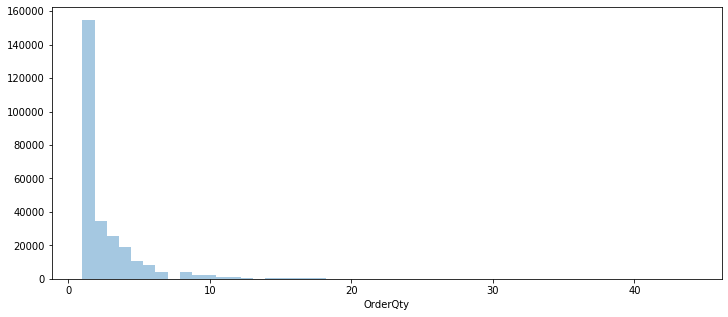

In [9]:
sns.distplot(df['OrderQty'],kde=False);

In [10]:
df['TerritoryID'].value_counts().sort_values(ascending=False)

4    133347
1     94711
5     15939
3     13933
2     12887
Name: TerritoryID, dtype: int64

In [11]:
df['ProductID'].value_counts().sort_values(ascending=False)

870    9210
712    6980
873    6568
711    6412
707    6301
       ... 
898      24
943      21
911      20
942      15
897       2
Name: ProductID, Length: 266, dtype: int64

In [12]:
len(df)

270817

In [13]:
# check for the duplicate rows in the overall dataset #
df[df.duplicated()==True].head()

,CustomerId,OrderDate,SalesOrderNumber,TerritoryID,ProductID,UnitPrice,OrderQty
3,11217,2014/01/03 00:00,SO76869,1,771,2039.994,1
15,11217,2014/01/03 00:00,SO76869,1,771,2039.994,1
16,11217,2014/01/03 00:00,SO76869,1,775,2024.994,2
23,11217,2014/01/03 00:00,SO76869,1,774,2039.994,1
25,11217,2014/01/03 00:00,SO76869,1,777,2024.994,1


In [14]:
# total duplicate rows #
len(df[df.duplicated()==True])

32004

In [15]:
# calculate the %duplicate rows #
percent_duplicate = (len(df[df.duplicated()==True]) / len(df)) * 100
print (f'Total exact duplicate rows in the dataset = {percent_duplicate:1.3}%')

Total exact duplicate rows in the dataset = 11.8%


In [16]:
# create a copy of the original dataset #
sales = df.copy()

In [17]:
# Remove the duplicate rows from the dataset #
sales.drop_duplicates(inplace=True,keep='first')

In [18]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238813 entries, 0 to 270816
Data columns (total 7 columns):
CustomerId          238813 non-null int64
OrderDate           238813 non-null object
SalesOrderNumber    238813 non-null object
TerritoryID         238813 non-null int64
ProductID           238813 non-null int64
UnitPrice           238813 non-null float64
OrderQty            238813 non-null int64
dtypes: float64(1), int64(4), object(2)
memory usage: 14.6+ MB


- All the features are non null 

In [19]:
sales.head()

,CustomerId,OrderDate,SalesOrderNumber,TerritoryID,ProductID,UnitPrice,OrderQty
0,11217,2014/01/03 00:00,SO76869,1,771,2039.994,1
1,11217,2014/01/03 00:00,SO297124,1,996,72.894,3
2,11217,2014/01/03 00:00,SO485914,1,957,1430.442,4
4,11217,2014/01/03 00:00,SO485914,1,885,602.346,2
5,11217,2014/01/03 00:00,SO202729,1,761,469.794,5


In [20]:
sales.tail()

,CustomerId,OrderDate,SalesOrderNumber,TerritoryID,ProductID,UnitPrice,OrderQty
270812,29597,2015/12/25 00:00,SO409300,5,990,323.994,3
270813,29880,2015/12/25 00:00,SO472280,5,711,34.990,1
270814,30085,2015/12/25 00:00,SO472235,5,711,34.990,1
270815,29561,2015/12/25 00:00,SO377943,5,759,469.794,8
270816,29896,2015/12/25 00:00,SO472326,5,930,35.000,1


### Feature Engineering 

#### Add the US holidays

In [21]:
from datetime import date
import holidays

In [22]:
# Fetch US holidays for the years of interest and store in a list #
holiday = [] 

for hol in holidays.UnitedStates(years = [2014,2015,2016]).keys():
    holiday.append(hol)

In [23]:
# print the US holidays in 2014 to 2016 #
for hol in holidays.UnitedStates(years = [2014,2015,2016]).items():
    print (hol)

(datetime.date(2016, 1, 1), "New Year's Day")
(datetime.date(2016, 1, 18), 'Martin Luther King, Jr. Day')
(datetime.date(2016, 2, 15), "Washington's Birthday")
(datetime.date(2016, 5, 30), 'Memorial Day')
(datetime.date(2016, 7, 4), 'Independence Day')
(datetime.date(2016, 9, 5), 'Labor Day')
(datetime.date(2016, 10, 10), 'Columbus Day')
(datetime.date(2016, 11, 11), 'Veterans Day')
(datetime.date(2016, 11, 24), 'Thanksgiving')
(datetime.date(2016, 12, 25), 'Christmas Day')
(datetime.date(2016, 12, 26), 'Christmas Day (Observed)')
(datetime.date(2014, 1, 1), "New Year's Day")
(datetime.date(2014, 1, 20), 'Martin Luther King, Jr. Day')
(datetime.date(2014, 2, 17), "Washington's Birthday")
(datetime.date(2014, 5, 26), 'Memorial Day')
(datetime.date(2014, 7, 4), 'Independence Day')
(datetime.date(2014, 9, 1), 'Labor Day')
(datetime.date(2014, 10, 13), 'Columbus Day')
(datetime.date(2014, 11, 11), 'Veterans Day')
(datetime.date(2014, 11, 27), 'Thanksgiving')
(datetime.date(2014, 12, 25), '

In [24]:
sales.index

Int64Index([     0,      1,      2,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            270807, 270808, 270809, 270810, 270811, 270812, 270813, 270814,
            270815, 270816],
           dtype='int64', length=238813)

- The indices are not sequential due to the removal of the duplicate rows
- Example, there is no index 3

In [25]:
sales.columns

Index(['CustomerId', 'OrderDate', 'SalesOrderNumber', 'TerritoryID',
       'ProductID', 'UnitPrice', 'OrderQty'],
      dtype='object')

In [26]:
# reset the index #
sales.reset_index(inplace=True)

In [27]:
sales.columns

Index(['index', 'CustomerId', 'OrderDate', 'SalesOrderNumber', 'TerritoryID',
       'ProductID', 'UnitPrice', 'OrderQty'],
      dtype='object')

In [28]:
sales.head()

,index,CustomerId,OrderDate,SalesOrderNumber,TerritoryID,ProductID,UnitPrice,OrderQty
0,0,11217,2014/01/03 00:00,SO76869,1,771,2039.994,1
1,1,11217,2014/01/03 00:00,SO297124,1,996,72.894,3
2,2,11217,2014/01/03 00:00,SO485914,1,957,1430.442,4
3,4,11217,2014/01/03 00:00,SO485914,1,885,602.346,2
4,5,11217,2014/01/03 00:00,SO202729,1,761,469.794,5


In [29]:
# remove the unwanted index converted to columns, due to reset_index #
sales.drop(['index'],inplace=True,axis=1)

In [30]:
sales.head()

,CustomerId,OrderDate,SalesOrderNumber,TerritoryID,ProductID,UnitPrice,OrderQty
0,11217,2014/01/03 00:00,SO76869,1,771,2039.994,1
1,11217,2014/01/03 00:00,SO297124,1,996,72.894,3
2,11217,2014/01/03 00:00,SO485914,1,957,1430.442,4
3,11217,2014/01/03 00:00,SO485914,1,885,602.346,2
4,11217,2014/01/03 00:00,SO202729,1,761,469.794,5


In [31]:
sales.index

RangeIndex(start=0, stop=238813, step=1)

In [32]:
# change the datatype of date column to datetime column #
sales['OrderDate'] = pd.to_datetime(sales['OrderDate'])

In [33]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238813 entries, 0 to 238812
Data columns (total 7 columns):
CustomerId          238813 non-null int64
OrderDate           238813 non-null datetime64[ns]
SalesOrderNumber    238813 non-null object
TerritoryID         238813 non-null int64
ProductID           238813 non-null int64
UnitPrice           238813 non-null float64
OrderQty            238813 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 12.8+ MB


- The datatype of OrderDate is changed to datetime64

In [34]:
# Drop the CustomerId and SalesOrderNumber as they are invoice fields #
sales.drop(['CustomerId','SalesOrderNumber'],inplace=True,axis=1)

In [35]:
sales.columns

Index(['OrderDate', 'TerritoryID', 'ProductID', 'UnitPrice', 'OrderQty'], dtype='object')

In [36]:
sales.head()

,OrderDate,TerritoryID,ProductID,UnitPrice,OrderQty
0,2014-01-03,1,771,2039.994,1
1,2014-01-03,1,996,72.894,3
2,2014-01-03,1,957,1430.442,4
3,2014-01-03,1,885,602.346,2
4,2014-01-03,1,761,469.794,5


### Add Holidays
- 1 if the date is a holiday 
- 0 if the date is Not a holiday

In [37]:
# check each row date if it is in the holiday list of 2014 to 2016 #
h = []

for i in range(len(sales)):
    if (sales['OrderDate'][i] in holiday):
        h.append(1)
    else:
        h.append(0)

In [38]:
sales['holiday'] = h

In [39]:
sales.head()

,OrderDate,TerritoryID,ProductID,UnitPrice,OrderQty,holiday
0,2014-01-03,1,771,2039.994,1,0
1,2014-01-03,1,996,72.894,3,0
2,2014-01-03,1,957,1430.442,4,0
3,2014-01-03,1,885,602.346,2,0
4,2014-01-03,1,761,469.794,5,0


In [40]:
sales[sales['holiday']==1].head()

,OrderDate,TerritoryID,ProductID,UnitPrice,OrderQty,holiday
1157,2014-02-17,1,707,34.99,1,1
1158,2014-02-17,1,753,3578.27,1,1
1159,2014-02-17,1,870,4.99,1,1
1160,2014-02-17,1,883,53.99,1,1
1161,2014-02-17,1,922,3.99,1,1


In [41]:
len(sales[sales['holiday']==1])

13811

- There are 13811 Order Dates which fall on a holiday 

### Add the following based on the OrderDate
- Year of sales 
- Weeknumber 
- Month of sales

In [42]:
# weekday #
wkday = []
for i in range(len(sales)):
    wkday.append(sales['OrderDate'][i].weekday())   
    
# year #
yr = []
for i in range(len(sales)):
    yr.append(sales['OrderDate'][i].year)   
    
# month #
mon = []
for i in range(len(sales)):
    mon.append(sales['OrderDate'][i].month)      
    

In [43]:
sales['day'] = wkday
sales['year'] = yr
sales['month'] = mon

In [44]:
sales.head()

,OrderDate,TerritoryID,ProductID,UnitPrice,OrderQty,holiday,day,year,month
0,2014-01-03,1,771,2039.994,1,0,4,2014,1
1,2014-01-03,1,996,72.894,3,0,4,2014,1
2,2014-01-03,1,957,1430.442,4,0,4,2014,1
3,2014-01-03,1,885,602.346,2,0,4,2014,1
4,2014-01-03,1,761,469.794,5,0,4,2014,1


In [45]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238813 entries, 0 to 238812
Data columns (total 9 columns):
OrderDate      238813 non-null datetime64[ns]
TerritoryID    238813 non-null int64
ProductID      238813 non-null int64
UnitPrice      238813 non-null float64
OrderQty       238813 non-null int64
holiday        238813 non-null int64
day            238813 non-null int64
year           238813 non-null int64
month          238813 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 16.4 MB


In [46]:
# add the weekend column, day value of 5 is Saturday and 6 is for Sunday #
def weekend(day):
    if day == 5 or day == 6:
        return 1
    else:
        return 0

In [47]:
sales['weekend'] = sales['day'].apply(weekend)

In [48]:
sales.head()

,OrderDate,TerritoryID,ProductID,UnitPrice,OrderQty,holiday,day,year,month,weekend
0,2014-01-03,1,771,2039.994,1,0,4,2014,1,0
1,2014-01-03,1,996,72.894,3,0,4,2014,1,0
2,2014-01-03,1,957,1430.442,4,0,4,2014,1,0
3,2014-01-03,1,885,602.346,2,0,4,2014,1,0
4,2014-01-03,1,761,469.794,5,0,4,2014,1,0


In [49]:
sales[sales['weekend']==1].head()

,OrderDate,TerritoryID,ProductID,UnitPrice,OrderQty,holiday,day,year,month,weekend
239,2014-01-19,1,779,1391.9940,6,0,6,2014,1,1
240,2014-01-19,1,743,714.7043,2,0,6,2014,1,1
241,2014-01-19,1,892,602.3460,1,0,6,2014,1,1
242,2014-01-19,1,801,672.2940,3,0,6,2014,1,1
243,2014-01-19,1,855,53.9940,1,0,6,2014,1,1


In [50]:
sales['year'].value_counts()

2015    177577
2014     60378
2016       858
Name: year, dtype: int64

### Season features
- The order dates are not evenly spaced
- The index.freq cannot be set to one of the standard freq strings to use the timeseries models
- Before adding any season feature we will group the data based on OrderDate and ProductID

#### Select a particular Territory and continue the analysis 

In [51]:
sales['TerritoryID'].value_counts().sort_values(ascending=False)

4    117721
1     83682
5     13824
3     12209
2     11377
Name: TerritoryID, dtype: int64

In [108]:
# Retrieve the sales of the selected territory #
sales4 = sales[sales['TerritoryID']==4]

In [109]:
sales4.head()

,OrderDate,TerritoryID,ProductID,UnitPrice,OrderQty,holiday,day,year,month,weekend
107268,2014-01-01,4,836,324.4527,1,1,2,2014,1,0
107269,2014-01-01,4,751,3578.2700,1,1,2,2014,1,0
107270,2014-01-01,4,775,3374.9900,1,1,2,2014,1,0
107271,2014-01-01,4,951,242.9940,5,1,2,2014,1,0
107272,2014-01-01,4,994,32.3940,5,1,2,2014,1,0


In [110]:
tsales = pd.DataFrame(sales4.groupby(['OrderDate','ProductID'],observed=True)['OrderQty'].sum())

In [111]:
tsales.head()

OrderQty
OrderDate  ProductID          
2014-01-01 707               2
           708               1
           711               1
           713               1
           725               6

In [112]:
tsales.reset_index(inplace=True)

In [113]:
tsales.head()

,OrderDate,ProductID,OrderQty
0,2014-01-01,707,2
1,2014-01-01,708,1
2,2014-01-01,711,1
3,2014-01-01,713,1
4,2014-01-01,725,6


In [114]:
len(sales4)

117721

#### add the columns which were dropped due to grouping
- Improvement --> define a function as below steps are repeated.

In [115]:
# weekday #
wkday = []
for i in range(len(tsales)):
    wkday.append(tsales['OrderDate'][i].weekday())   
    
# year #
yr = []
for i in range(len(tsales)):
    yr.append(tsales['OrderDate'][i].year)   
    
# month #
mon = []
for i in range(len(tsales)):
    mon.append(tsales['OrderDate'][i].month)   

In [116]:
tsales['day'] = wkday
tsales['year'] = yr
tsales['month'] = mon

In [117]:
tsales.head()

,OrderDate,ProductID,OrderQty,day,year,month
0,2014-01-01,707,2,2,2014,1
1,2014-01-01,708,1,2,2014,1
2,2014-01-01,711,1,2,2014,1
3,2014-01-01,713,1,2,2014,1
4,2014-01-01,725,6,2,2014,1


In [118]:
tsales['weekend'] = tsales['day'].apply(weekend)

In [119]:
tsales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48004 entries, 0 to 48003
Data columns (total 7 columns):
OrderDate    48004 non-null datetime64[ns]
ProductID    48004 non-null int64
OrderQty     48004 non-null int64
day          48004 non-null int64
year         48004 non-null int64
month        48004 non-null int64
weekend      48004 non-null int64
dtypes: datetime64[ns](1), int64(6)
memory usage: 2.6 MB


In [120]:
# check each row date if it is in the holiday list of 2014 to 2016 #
h_t = []

for i in range(len(tsales)):
    if (tsales['OrderDate'][i] in holiday):
        h_t.append(1)
    else:
        h_t.append(0)

In [121]:
tsales['holiday'] =  h_t

In [122]:
tsales.head()

,OrderDate,ProductID,OrderQty,day,year,month,weekend,holiday
0,2014-01-01,707,2,2,2014,1,0,1
1,2014-01-01,708,1,2,2014,1,0,1
2,2014-01-01,711,1,2,2014,1,0,1
3,2014-01-01,713,1,2,2014,1,0,1
4,2014-01-01,725,6,2,2014,1,0,1


### Summary so far ... 
- The data is cleaned (duplicate rows, null values, dtypes of date column, columns removed)
- Holiday, weekend, year, month, weekday information is added as features
- Next is to add the seasonal features 



Considerations to add the new features for season
- In time series analysis, the lagged values are important. 
- The forecasting models like AR, ARMA, ARIMA, VAR, VARMAX are auto regressed.
- One important feature is the differencing order, like difference in sales from previous time period
- Also, the previous time period sales can be an important feature in the predictive model

In [123]:
# first order difference of the OrderQty #
tsales['OrderQty_Diff1'] = tsales['OrderQty'].diff()

In [124]:
# second order difference of the OrderQty #
tsales['OrderQty_Diff2'] = tsales['OrderQty_Diff1'].diff()

In [125]:
# add the previous day sale figure of each individual product of the territory #
tsales['OrderQty_Prev1'] = tsales.groupby(['ProductID'])['OrderQty'].shift()

In [126]:
# add the previous day sale figure of each individual product of the territory #
tsales['OrderQty_Prev2'] = tsales.groupby(['ProductID'])['OrderQty'].shift(periods=2)

In [127]:
tsales.head()

,OrderDate,ProductID,OrderQty,day,year,month,weekend,holiday,OrderQty_Diff1,OrderQty_Diff2,OrderQty_Prev1,OrderQty_Prev2
0,2014-01-01,707,2,2,2014,1,0,1,NaN,NaN,NaN,NaN
1,2014-01-01,708,1,2,2014,1,0,1,-1.0,NaN,NaN,NaN
2,2014-01-01,711,1,2,2014,1,0,1,0.0,1.0,NaN,NaN
3,2014-01-01,713,1,2,2014,1,0,1,0.0,0.0,NaN,NaN
4,2014-01-01,725,6,2,2014,1,0,1,5.0,5.0,NaN,NaN


- NaNs are introduced due to differencing and shift

In [128]:
tsales.dropna(inplace=True)

In [129]:
tsales.head(10)

,OrderDate,ProductID,OrderQty,day,year,month,weekend,holiday,OrderQty_Diff1,OrderQty_Diff2,OrderQty_Prev1,OrderQty_Prev2
96,2014-01-04,707,1,5,2014,1,1,0,-2.0,-4.0,6.0,2.0
98,2014-01-04,711,1,5,2014,1,1,0,-1.0,-2.0,1.0,1.0
103,2014-01-04,751,2,5,2014,1,1,0,1.0,2.0,1.0,1.0
105,2014-01-04,778,2,5,2014,1,1,0,0.0,0.0,1.0,1.0
122,2014-01-07,707,1,1,2014,1,0,0,-2.0,-4.0,1.0,6.0
123,2014-01-07,708,1,1,2014,1,0,0,0.0,2.0,12.0,1.0
124,2014-01-07,712,1,1,2014,1,0,0,0.0,0.0,2.0,2.0
126,2014-01-07,715,4,1,2014,1,0,0,3.0,3.0,1.0,10.0
132,2014-01-07,750,2,1,2014,1,0,0,-1.0,-3.0,1.0,1.0
136,2014-01-07,782,4,1,2014,1,0,0,3.0,3.0,1.0,2.0


- ProductID is an integer column
- This should be changed to categorical, else the model will pick this to be a continuous predictor

In [130]:
# change the datatype of ProductID to string #
tsales['ProductID'] =  tsales['ProductID'].astype('str')

In [131]:
tsales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47473 entries, 96 to 48003
Data columns (total 12 columns):
OrderDate         47473 non-null datetime64[ns]
ProductID         47473 non-null object
OrderQty          47473 non-null int64
day               47473 non-null int64
year              47473 non-null int64
month             47473 non-null int64
weekend           47473 non-null int64
holiday           47473 non-null int64
OrderQty_Diff1    47473 non-null float64
OrderQty_Diff2    47473 non-null float64
OrderQty_Prev1    47473 non-null float64
OrderQty_Prev2    47473 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(6), object(1)
memory usage: 4.7+ MB


#### Encode the ProductID feature

In [132]:
ProductID_dummies = pd.get_dummies(tsales['ProductID'],drop_first=True)

In [133]:
# remove the original ProductID column from the dataset #
tsales.drop('ProductID',axis=1,inplace=True)

In [134]:
# concat the encoded ProductID #
tsales_encoded = pd.concat([tsales,ProductID_dummies],axis=1)

In [135]:
tsales_encoded.columns

Index(['OrderDate', 'OrderQty', 'day', 'year', 'month', 'weekend', 'holiday',
       'OrderQty_Diff1', 'OrderQty_Diff2', 'OrderQty_Prev1',
       ...
       '989', '990', '991', '992', '993', '994', '996', '997', '998', '999'],
      dtype='object', length=275)

In [136]:
tsales_encoded.head()

,OrderDate,OrderQty,day,year,month,weekend,holiday,OrderQty_Diff1,OrderQty_Diff2,OrderQty_Prev1,...,989,990,991,992,993,994,996,997,998,999
96,2014-01-04,1,5,2014,1,1,0,-2.0,-4.0,6.0,...,0,0,0,0,0,0,0,0,0,0
98,2014-01-04,1,5,2014,1,1,0,-1.0,-2.0,1.0,...,0,0,0,0,0,0,0,0,0,0
103,2014-01-04,2,5,2014,1,1,0,1.0,2.0,1.0,...,0,0,0,0,0,0,0,0,0,0
105,2014-01-04,2,5,2014,1,1,0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
122,2014-01-07,1,1,2014,1,0,0,-2.0,-4.0,1.0,...,0,0,0,0,0,0,0,0,0,0


### Training and Testing Data Split
- As this is a forecast problem and had features of previous period sales, difference values, the data split would not be shuffled

In [137]:
len(tsales_encoded)

47473

In [138]:
# figure out the 80% value for training and 20% for testing #
per_80 = int(round(0.8*len(tsales_encoded),0))
per_80

37978

In [139]:
# create sets for training and testing data #
for_training = tsales_encoded[:per_80]
for_testing = tsales_encoded[per_80:]

In [140]:
# create X_train,y_train, X_test and y_test dataset #
X_train = for_training.drop(['OrderQty','OrderDate'],axis=1)
y_train = for_training['OrderQty']

X_test = for_testing.drop(['OrderQty','OrderDate'],axis=1)
y_test = for_testing['OrderQty']

### Model Selection 
Ensemble models to try:
- Random Forest Regressor
- Gradient Boosting Regressor


In [141]:
# import the ensemble regressor models #
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

# for model evaluation #
from statsmodels.tools.eval_measures import mse,rmse
from sklearn.metrics import mean_squared_error

In [142]:
rfmodel = RandomForestRegressor(n_estimators=100)

In [143]:
rfmodel.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [144]:
rf_predictions = rfmodel.predict(X_test)

In [145]:
rf_rmse = rmse(y_test,rf_predictions)

In [146]:
gbmodel = GradientBoostingRegressor(n_estimators=100)

In [147]:
gbmodel.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [148]:
gb_predictions = gbmodel.predict(X_test)

In [149]:
gb_rmse = rmse(y_test,gb_predictions)

In [150]:
print (f'RMSE using Random Forest Regressor = {rf_rmse:2.5}')
print (f'RMSE using Gradient Boosting Regressor = {gb_rmse:1.5}')       

RMSE using Random Forest Regressor = 3.2605
RMSE using Gradient Boosting Regressor = 3.2318


In [151]:
y_test.describe()

count    9495.000000
mean        6.177567
std         7.707721
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max       122.000000
Name: OrderQty, dtype: float64

Reflection on Model Summary 
- Gradient Boosting performs faster and has a better rmse score compared to Random Forest Regressor
- The obtained RMSE is less than the mean, median and well under the standard deviation of the y_test 
- This indicates that the model has performed well in predictions

In [158]:
# create dataframe of the y_test and its predictions using the GradientBoost model #
frame = { 'True Y': y_test, 'GB Predictions': gb_predictions,'RF Predictions':rf_predictions} 

In [159]:
compare_results = pd.DataFrame(frame)

In [160]:
compare_results

,True Y,GB Predictions,RF Predictions
38509,7,4.066312,5.62
38510,8,2.896698,2.17
38511,4,2.815044,1.67
38512,19,19.877301,16.96
38513,4,6.015990,1.90
...,...,...,...
47999,6,6.364559,5.04
48000,2,2.602509,1.14
48001,3,2.917361,2.14
48002,3,2.432081,2.05


## Conclusion


- Both Random Forest and Gradient Boosting returned equivalent RMSE values
- The steps were repeated with different TerritoryID 
- For territories 2,3 and 5, Random Forest performed better. These territories had relatively lesser
  number of observations compared to TerritoryID 1 and 4. 
- For TerritoryID 1 and 4, GB model returned RMSE better than RF model. 

Further Improvements
- The dataset can be group by TerritoryID, ProductID and OrderDate and the entire steps can be repeated
- Cross Validation using the TimerSeriesSplit can be performed. 
- The OrderQty is skewed. The model can be retrained after scaling the OrderQty value. 




Thank You